# AirBnB Prices Analysis and Prediction

Problem Statement: To predict the AirBnB prices closest to the real time prices.

Let us start off by importing the data and the necessary packages

In [1]:
#Uncomment the commands below for Linux based Oses
# !python -m pip install vaderSentiment
# !python -m pip install xgboost
# !python -m pip install nltk

#Uncomment the commands below for Unix based Oses
# !pip install vaderSentiment
# !pip isntall xgboost
# !pip install nltk

# Load required libraries and datasets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#uncomment to download this package
# nltk.download('stopwords')  

In [3]:
#Replace the path with the path to the file
path = "C:\\Users\\revedala\\Desktop\\CaseStudy\\"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [4]:
train.shape

(74111, 29)

From the above, we can see that there are 29 features(including the target column). We have to pick out the best features to ensure that the model isnt overfitted. But before we do that, let us look at the spread of the data.

## Data Understanding

### Missing Value Analysis
This is the most important step to help us understand the importance of the data. Let us first do an analysis of the missing values and see if any of the columns have significant number of missing values

#### Training Data:

In [5]:
((train.isnull().sum()/len(train.index))*100)

id                         0.000000
log_price                  0.000000
property_type              0.000000
room_type                  0.000000
amenities                  0.000000
accommodates               0.000000
bathrooms                  0.269865
bed_type                   0.000000
cancellation_policy        0.000000
cleaning_fee               0.000000
city                       0.000000
description                0.000000
first_review              21.405729
host_has_profile_pic       0.253674
host_identity_verified     0.253674
host_response_rate        24.691341
host_since                 0.253674
instant_bookable           0.000000
last_review               21.355804
latitude                   0.000000
longitude                  0.000000
name                       0.000000
neighbourhood              9.272578
number_of_reviews          0.000000
review_scores_rating      22.563452
thumbnail_url             11.086074
zipcode                    1.303450
bedrooms                   0

From the above, none of the columns have a null value percentage above 25% and hence we dont need to drop any of the columns. We can drop the records from columns where the percentage is less than 5%

In [6]:
percentage = (train.isnull().sum()/len(train.index))*100
drop_na = percentage[((percentage>0) & (percentage<5))].index.to_list()
train = train.dropna(subset=drop_na)

In [7]:
train.isnull().sum()[train.isnull().sum()>0].index.to_list()

['first_review',
 'host_response_rate',
 'last_review',
 'neighbourhood',
 'review_scores_rating',
 'thumbnail_url']

The date columns(`first_reveiew`, `last_review`) are handled in the Date Analysis segment. The `host_response_rate` is also handled below. For review_scores_rating, let us look at the different metrics

In [8]:
train['review_scores_rating'].describe()

count    56320.000000
mean        94.071307
std          7.813483
min         20.000000
25%         92.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

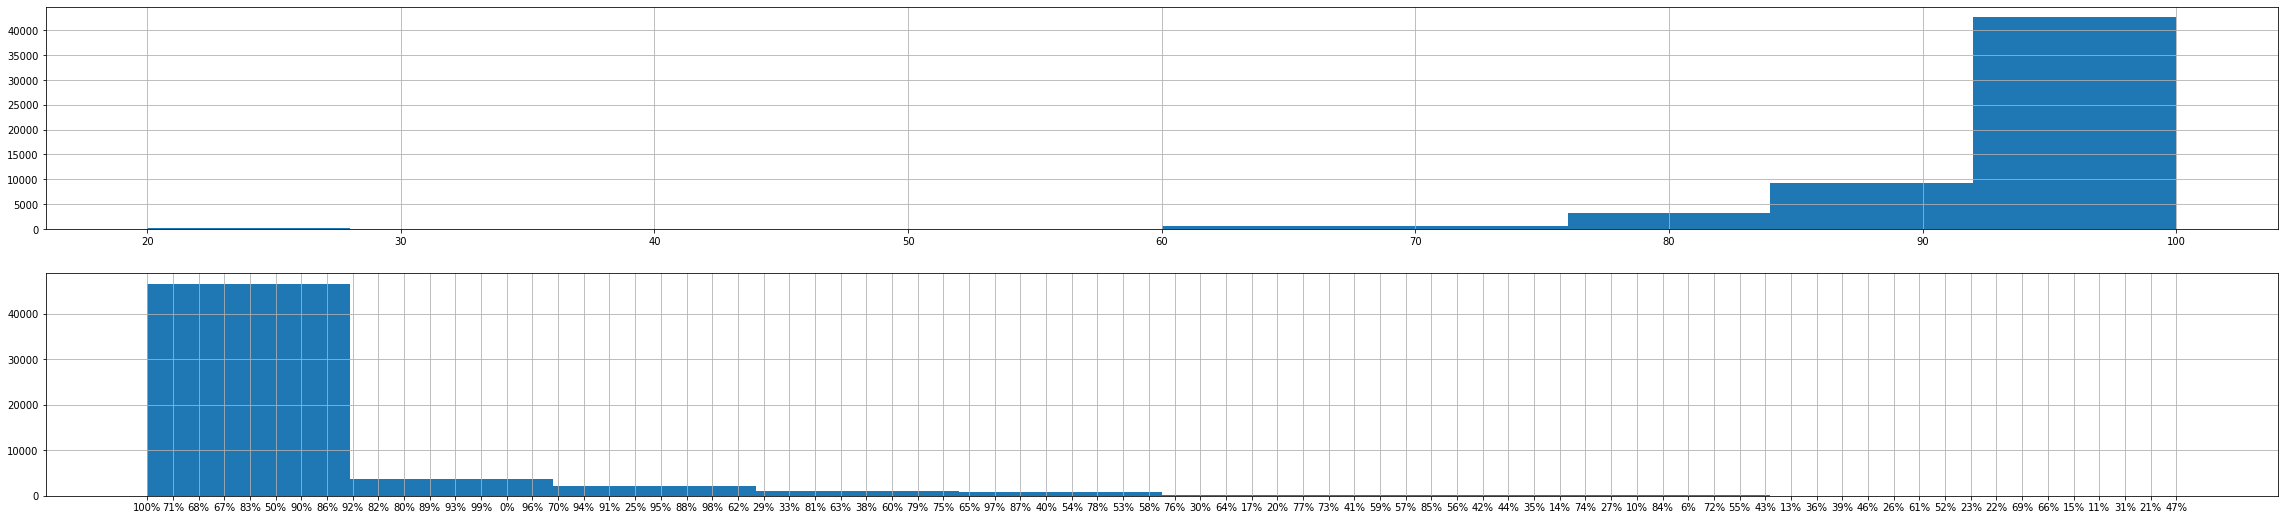

In [9]:
plt.figure(figsize=(40,9))
plt.subplot(2,1,1)
train['review_scores_rating'].hist()
plt.subplot(2,1,2)
train['host_response_rate'].hist()
#let us randomize the imputing by using the interpolate function

The percentage of rows with null values greater than 5 is negligable. Lets just drop these records as they wouldnt contribute to the analysis. Let us also drop the `id` feature since it doesnt contribute to any form of analysis

In [10]:
train = train[train.isnull().sum(axis=1)<=5]
train.drop(['id'],inplace=True,axis=1)

#### Test Data:

In [11]:
(test.isnull().sum()/len(test.index))*100

id                         0.000000
property_type              0.000000
room_type                  0.000000
amenities                  0.000000
accommodates               0.000000
bathrooms                  0.310315
bed_type                   0.000000
cancellation_policy        0.000000
cleaning_fee               0.000000
city                       0.000000
description                0.054993
first_review              21.352816
host_has_profile_pic       0.216042
host_identity_verified     0.216042
host_response_rate        24.770210
host_since                 0.216042
instant_bookable           0.000000
last_review               21.309608
latitude                   0.000000
longitude                  0.000000
name                       0.019640
neighbourhood              9.682615
number_of_reviews          0.000000
review_scores_rating      22.456595
thumbnail_url             11.230262
zipcode                    1.260900
bedrooms                   0.109985
beds                       0

The majority of the null values are handled in the upcoming sections. We will interpolate it with the nearest just before prediction to ensure that most the rest of the smaller missing values are imputed

### Categorical Features Analysis
There are multiple categorical columns in the dataset. Let us see how they are spread across different categories

In [12]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72539 entries, 0 to 74110
Data columns (total 28 columns):
log_price                 72539 non-null float64
property_type             72539 non-null object
room_type                 72539 non-null object
amenities                 72539 non-null object
accommodates              72539 non-null int64
bathrooms                 72539 non-null float64
bed_type                  72539 non-null object
cancellation_policy       72539 non-null object
cleaning_fee              72539 non-null bool
city                      72539 non-null object
description               72539 non-null object
first_review              57153 non-null object
host_has_profile_pic      72539 non-null object
host_identity_verified    72539 non-null object
host_response_rate        54905 non-null object
host_since                72539 non-null object
instant_bookable          72539 non-null object
last_review               57184 non-null object
latitude                  72

#### Property Type
Let us see how the values are spread across the property type and make necessary changes

In [13]:
train['property_type'].astype('category').value_counts()

Apartment             47897
House                 16205
Condominium            2619
Townhouse              1661
Loft                   1216
Other                   593
Guesthouse              490
Bed & Breakfast         452
Bungalow                359
Villa                   176
Dorm                    134
Guest suite             121
Camper/RV                93
Timeshare                76
Cabin                    70
In-law                   70
Hostel                   69
Boutique hotel           68
Boat                     63
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Island                    1
Casa particular           1
Lighthouse                1
Name: property_type, dtype: int64

From the above, it is clear that majority of the property_types are present in the first 6 types given above. We can consider rest of them to fall under the category of `others`

In [14]:
accepted_properties = train['property_type'].astype('category').value_counts()[:5].index.to_list()
def change_type(value):
    if value in accepted_properties:
        return value
    else:
        return 'Other'
train['property_type'] = train['property_type'].apply(lambda x: change_type(x))

#Replicate the same for the test data
test['property_type'] = test['property_type'].apply(lambda x: change_type(x))

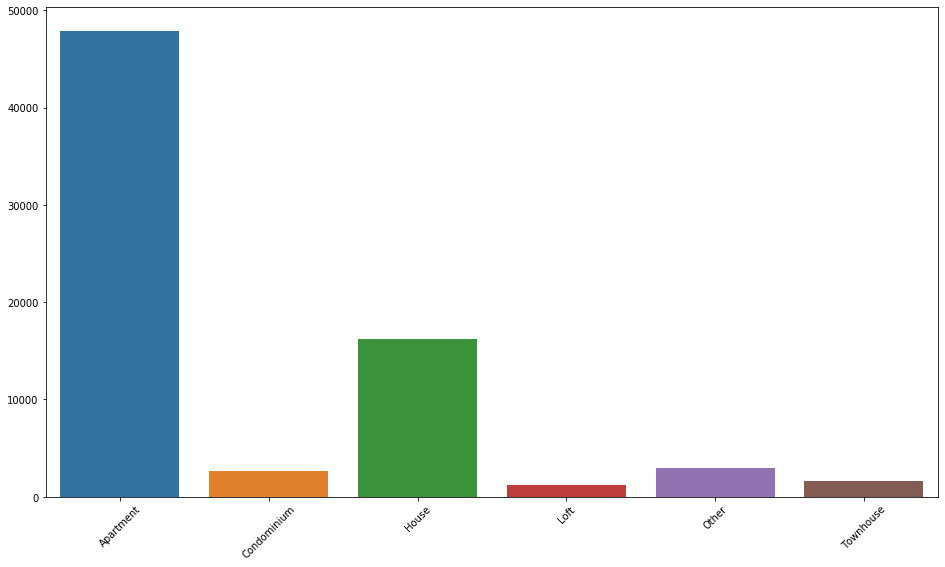

In [15]:
property_final = train['property_type'].astype('category').value_counts()
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
sns.barplot(property_final.index, property_final.values)

#### Room Type
Let us see how the different categories of Room type are spread

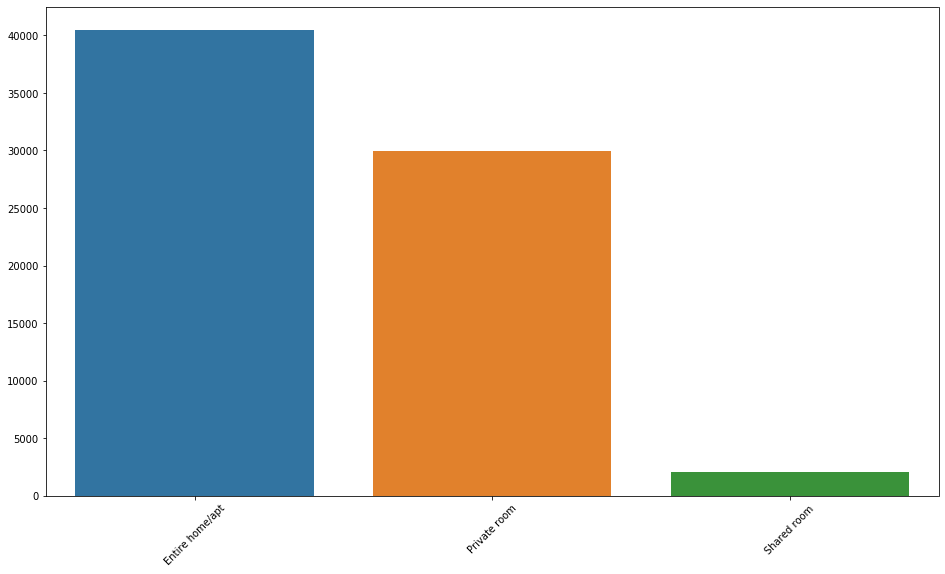

In [16]:
room_type = train['room_type'].astype('category').value_counts()
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
sns.barplot(room_type.index, room_type.values)

#### Amenities
Since this is a dictionary. It has to be pre-processed a little. Let us also create a new feature which keeps a track of the number of amenities in a particular AirBnB. The assumptions we are making here is that there must be some kind of relationship between the number of amenities offered and the price of the AirBnB

In [17]:
train['amenities'] = train['amenities'].apply(lambda x:x.strip("'{").strip("}").replace('"','').split(','))
test['amenities'] = test['amenities'].apply(lambda x:x.strip("'{").strip("}").replace('"','').split(','))
amenities_set = set(word for row in train['amenities'] for word in row )
amenities_set_test = set(word for row in test['amenities'] for word in row )

In [18]:
#Removing the unnecessary values
unnecessary_values = ['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50','']
def remove_amenity(list_amenity):
    for amenity in list_amenity:
        if amenity in unnecessary_values:
            list_amenity.remove(amenity)
    return list_amenity

train['amenities'] = train['amenities'].apply(lambda x:remove_amenity(x))
test['amenities'] = test['amenities'].apply(lambda x:remove_amenity(x))
train['no_of_amenities'] = train['amenities'].apply(lambda x: len(x))
test['no_of_amenities'] = test['amenities'].apply(lambda x: len(x))

#### City
Let us see the different categories of cities. An indepth analysis has been done on Tableau and presented in the deck

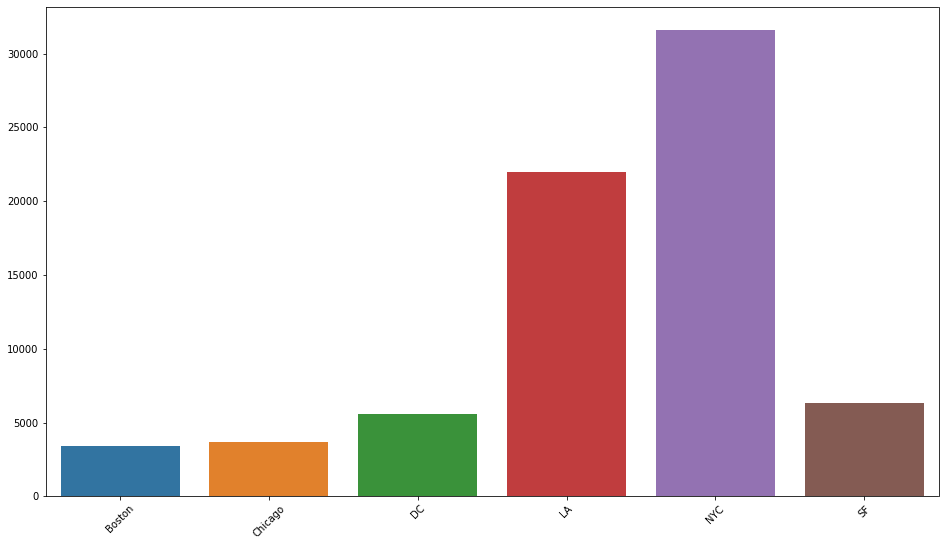

In [19]:
city_count = train['city'].astype('category').value_counts()
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
sns.barplot(city_count.index, city_count.values)

Most people pick up AirBnB's based on its proximity to major parts of the city. Here we consider distance from the center of the city and the airport. The coordinates for these were taken off the internet

In [20]:
#Coordinates for the two landmarks
center_map = {"NYC":[40.730610,-73.935242],"SF":[37.773972, -122.431297],"DC":[38.889931,-77.009003],"LA":[34.052235, -118.243683],"Chicago":[41.881832, -87.623177],"Boston":[42.361145, -71.057083]}
airport_map = {"Boston":[42.366978,-71.022362],"NYC":[40.6413111,-73.7781391],"SF":[37.615223, -122.389977],"DC":[38.9534,-77.4477],"LA":[33.942791, -118.410042],"Chicago":[41.977226, -87.836723]}

#Creating features in the train dataset
train['center_lat'] = train['city'].apply(lambda x: center_map[x][0])
train['air_lat'] = train['city'].apply(lambda x: airport_map[x][0])
train['center_long'] = train['city'].apply(lambda x: center_map[x][1])
train['air_long'] = train['city'].apply(lambda x: airport_map[x][1])
train['distance_to_center'] = np.sqrt((train['center_lat'] - train['latitude'])**2 + (train['center_long'] - train['longitude'])**2)
train['distance_to_airport'] = np.sqrt((train['air_lat'] - train['latitude'])**2 + (train['air_long'] - train['longitude'])**2)


#Creating the features in the test dataset
test['center_lat'] = test['city'].apply(lambda x: center_map[x][0])
test['air_lat'] = test['city'].apply(lambda x: airport_map[x][0])
test['center_long'] = test['city'].apply(lambda x: center_map[x][1])
test['air_long'] = test['city'].apply(lambda x: airport_map[x][1])
test['distance_to_center'] = np.sqrt((test['center_lat'] - test['latitude'])**2 + (test['center_long'] - test['longitude'])**2)
test['distance_to_airport'] = np.sqrt((test['air_lat'] - test['latitude'])**2 + (test['air_long'] - test['longitude'])**2)

#### Bed Type

Lets see the different types of beds available in our dataset

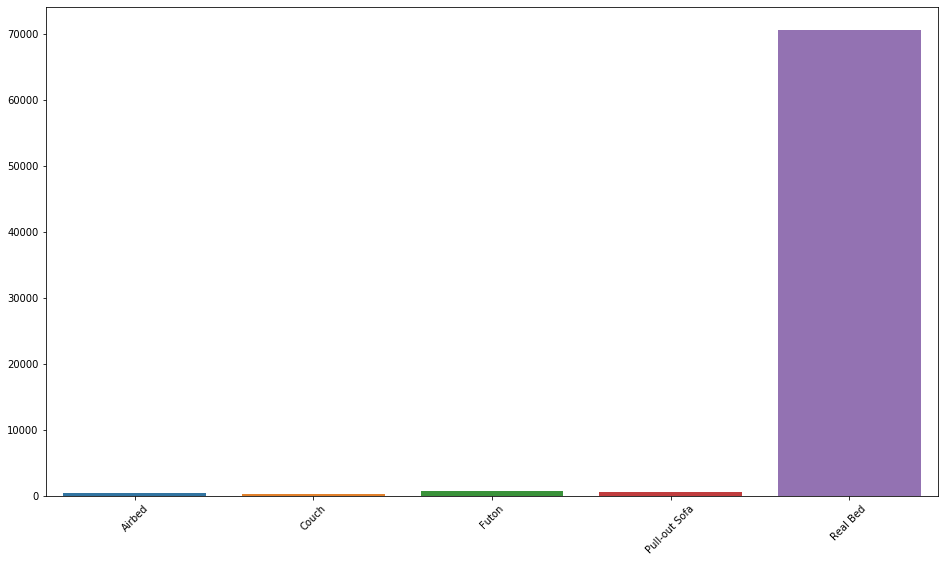

In [21]:
bed_type = train['bed_type'].astype('category').value_counts()
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
sns.barplot(bed_type.index, bed_type.values)

The bed type is also majorily dependent on `Real Bed`. Let us convert all the other categories into `Other Bed`

In [22]:
#train data
train['bed_type'] = train['bed_type'].apply(lambda x: x if x=='Real Bed' else 'Other Bed')

#test data
test['bed_type'] = test['bed_type'].apply(lambda x: x if x=='Real Bed' else 'Other Bed')

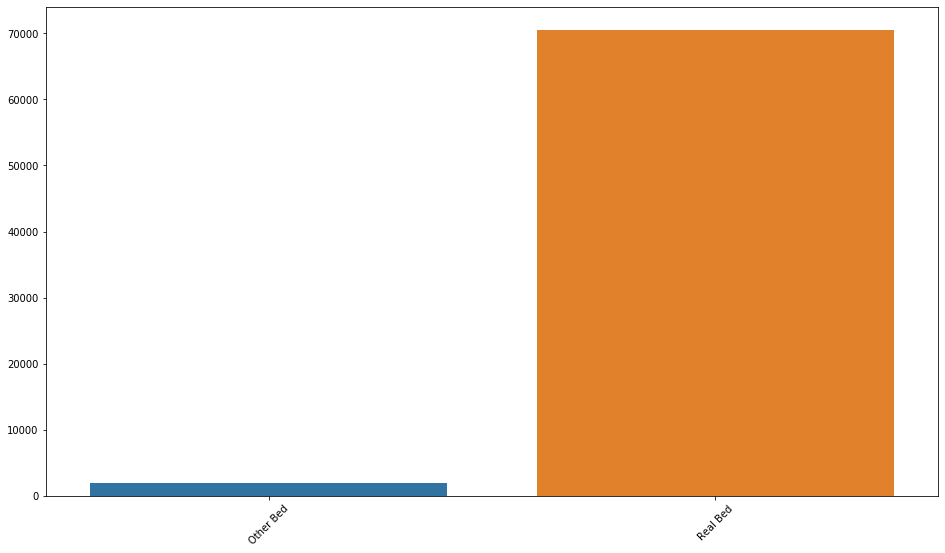

In [23]:
bed_type = train['bed_type'].astype('category').value_counts()
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
sns.barplot(bed_type.index, bed_type.values)

This still doesnt have equal representation and therefore the model could get biased against real beds. Hence, let us drop this column while training

In [24]:
train['cancellation_policy'].astype('category').value_counts()

strict             31764
flexible           21944
moderate           18708
super_strict_30      107
super_strict_60       16
Name: cancellation_policy, dtype: int64

Since we have very less data on the different strict levels, let us convert them into `super_strict`

In [25]:
accepted_cancellation = train['cancellation_policy'].astype('category').value_counts()[:3].index.to_list()
def convert_cancellation(value):
    if value in accepted_cancellation:
        return value
    else:
        return 'super_strict'
#test data
train['cancellation_policy'] = train['cancellation_policy'].apply(lambda x: convert_cancellation(x))

#test data
test['cancellation_policy'] = test['cancellation_policy'].apply(lambda x: convert_cancellation(x))

### Incorrectly Typed Features

#### Date Columns
An initial look at the dataset set part the following columns:

- `first_review`
- `last_review`
- `host_since`

These columns were wrongly typed as **object** by python. Let us correct this and while we are at it, create some useful features

In [26]:
# train_numeric = pd.get_dummies(train,columns=dummy_column,drop_first=True)
train['first_review'] = pd.to_datetime(train['first_review'])
train['last_review'] = pd.to_datetime(train['last_review'])

#Creating a feature to find out the number of days between the first and last review
train['days_between_reviews'] = (train['last_review'] - train['first_review']).dt.days
train['days_between_reviews'].fillna(0.0,inplace=True)

#Creating a feature to find out the number of the days the AirBnB has been a host for
train['host_since'] = pd.to_datetime(train['host_since'])
most_dates = pd.to_datetime(train['host_since'].mode())
train['host_since'].fillna(most_dates,inplace=True)

#Creating a feature to track the number of years since the AirBnB was created
current_date = pd.to_datetime(train['host_since'].max())
train['years_since_establishment'] = ((current_date - train['host_since']).dt.days)/364.25

#Replicating the above on the test data
test['first_review'] = pd.to_datetime(test['first_review'])
test['last_review'] = pd.to_datetime(test['last_review'])
test['days_between_reviews'] = (test['last_review'] - test['first_review']).dt.days
test['days_between_reviews'].fillna(0.0,inplace=True)
test['host_since'] = pd.to_datetime(test['host_since'])
most_dates = pd.to_datetime(test['host_since'].mode())
test['host_since'].fillna(most_dates,inplace=True)
test['years_since_establishment'] = ((current_date - test['host_since']).dt.days)/364.25

Let us derive a few insights from this data

C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Price')

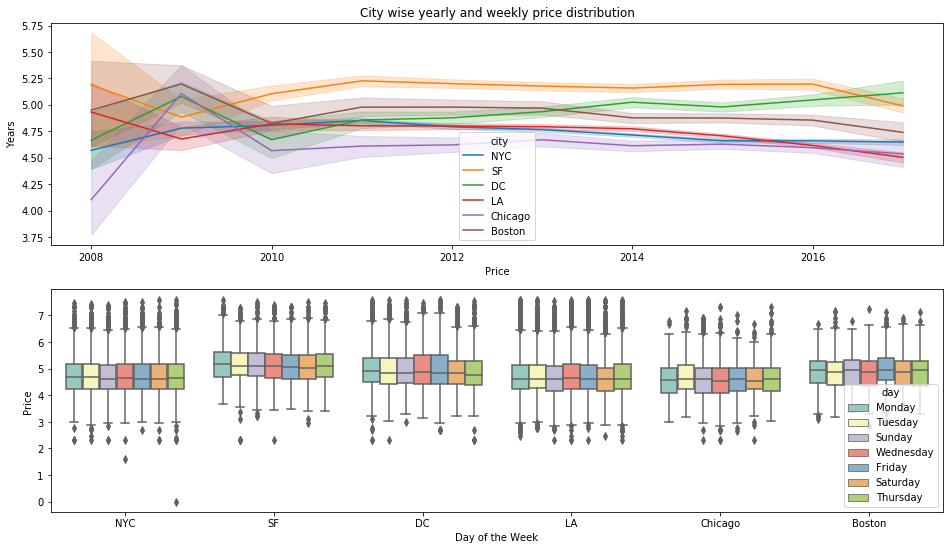

In [27]:
train_date_analysis = train[['first_review','last_review','host_since','log_price','city','years_since_establishment']]
train_date_analysis['year_of_establishment'] = train_date_analysis['host_since'].dt.year
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
train_date_analysis['day'] = train_date_analysis['host_since'].dt.dayofweek.map(dayOfWeek)

#Lets see how the price changes based on the years since establishment for every city
plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
plt.title('City wise yearly and weekly price distribution')
sns.lineplot(x='year_of_establishment', y='log_price', hue='city', data=train_date_analysis)
plt.xlabel('Price')
plt.ylabel('Years')

plt.subplot(2,1,2)
sns.boxplot(x='city',y='log_price',palette="Set3",data=train_date_analysis,hue='day')
plt.xlabel('City')
plt.ylabel('Price')

An indepth city-wise price-time analysis has been done using Tableau in the presentation deck

#### ZipCode 
The zipcodes have to be cleaned out a little and necessary imputations have to be made

In [28]:
# Train dataset
train['zipcode'].fillna('0',inplace=True)
train['zipcode'].apply(lambda x: str(x) if type(x)!=str else x)
train['zipcode'] = train['zipcode'].apply(lambda x: x.replace('\r',""))
train['zipcode'] = train['zipcode'].apply(lambda x: x.replace('\n',""))
train['zipcode'] = train['zipcode'].apply(lambda x: x if len(x)==5 else '0')
train['zipcode'] = train['zipcode'].apply(lambda x: '0' if x==" " else x)
train['zipcode'] = train['zipcode'].apply(lambda x: 0 if "-" in str(x) else x)
train['zipcode'] = pd.to_numeric(train['zipcode'])


# Test Dataset
test['zipcode'].fillna('0',inplace=True)
test['zipcode'].apply(lambda x: str(x) if type(x)!=str else x)
test['zipcode'] = test['zipcode'].apply(lambda x: x.replace('\r',""))
test['zipcode'] = test['zipcode'].apply(lambda x: x.replace('\n',""))
test['zipcode'] = test['zipcode'].apply(lambda x: x if len(x)==5 else '0')
test['zipcode'] = test['zipcode'].apply(lambda x: '0' if x==" " else x)
test['zipcode'] = test['zipcode'].apply(lambda x: 0 if "-" in str(x) else x)
test['zipcode'] = pd.to_numeric(test['zipcode'])

After some analysis using Tableau(explained in the deck), I was able to find some wrongly labelled zipcodes. 

Labelled = San Fransico
`15074`
This is the postal code of a county in Pennsylvania.

Labelled = Los Angeles
`10023`
This is the postal code of a county in NYC.

Labelled = DC
`11238`
This is the postal code of a county in Brooklyn(NYC).

Labelled = NYC
`99135`
This is the postal code of a county in DC.

Since we arent aware if the coordinates are erroneous or the label, its better to drop the records

In [29]:
dropped_pincodes = [15074, 10023, 11238, 99135]
train = train[~train.zipcode.isin(dropped_pincodes)]

In [30]:
train['review_scores_rating'] = pd.to_numeric(train['review_scores_rating'])
train['host_response_rate'] = pd.to_numeric(train['host_response_rate'].apply(lambda x: x.strip('%') if type(x)==str else x))

#test
test['review_scores_rating'] = pd.to_numeric(test['review_scores_rating'])
test['host_response_rate'] = pd.to_numeric(test['host_response_rate'].apply(lambda x: x.strip('%') if type(x)==str else x))


train['cleaning_fee'] = train['cleaning_fee'].astype('int64')
test['cleaning_fee'] = test['cleaning_fee'].astype('int64')

train['review_scores_rating'].interpolate(method='nearest',inplace=True)
train['host_response_rate'].interpolate(method='nearest',inplace=True)
test['review_scores_rating'].interpolate(method='nearest',inplace=True)
test['host_response_rate'].interpolate(method='nearest',inplace=True)

### Text Data analysis
Let us derive some insights from the texual data


#### Description and Name Columns
The dataset contains two columns which have textual data. Let us analysis these features and see their correlation to the `log_price`

In [31]:
train['description'].fillna('',inplace=True)
test['description'].fillna('',inplace=True)

In [32]:
stop = stopwords.words('english')

Let us remove the punctuations, case senitize the sentences and also remove the stop words

In [33]:
#Train
train['description'] = train['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['description'] = train['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['description'] = train['description'].str.replace('[^\w\s]','')

#test
test['description'] = test['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test['description'] = test['description'].str.replace('[^\w\s]','')

In [34]:
# train['word_count_description'] = train['description'].str.split().str.len()
train['word_count_name'] = train['name'].str.split().str.len()

#Test
# test['word_count_description'] = test['description'].str.split().str.len()
test['word_count_name'] = test['name'].str.split().str.len()

Let us also derive the sentiments from the description and see how it effects the prices. A positive description psychologically impacts the viewer and hence attracts him/her to it therefore increasing the demand for it. Hence, the positive score of the description might impact the prediction

In [35]:
#this cell takes a while to run
analyser = SentimentIntensityAnalyzer()
def get_score(sentence):
    return analyser.polarity_scores(sentence)
train['compound_scores'] = train['description'].apply(lambda x: get_score(x)['compound']*100)
train['pos_scores'] = train['description'].apply(lambda x: get_score(x)['pos']*100)
test['compound_scores'] = test['description'].apply(lambda x: get_score(x)['compound']*100)
test['pos_scores'] = test['description'].apply(lambda x: get_score(x)['pos']*100)

Lets export this data for further analysis in Tableau

In [36]:
train.to_csv('tableau_train.csv',index=False)

## Data Cleaning

### Drop Unnecessary Columns
Lets drop the unnecessary columns. Most of the features mentioned below either have no logical correlation with the `log_price` or have been used to derive other features. The only column that was left out completely was `neighbourhood`. This column was dropped since it was inconsistent with the test data. The `neighbourhood` values of the test dataset werent a sub set of the train set but instead had new neighbourhoods present. This meant that the model would have to predict on unseen values and hence it was better left out of analysis

In [37]:
train.drop(['latitude','longitude','name','description','amenities','neighbourhood','thumbnail_url','host_since','last_review','first_review','center_lat','center_long','bed_type','air_long','air_lat','city'],inplace=True,axis=1)
test.drop(['latitude','longitude','name','description','amenities','neighbourhood','thumbnail_url','host_since','last_review','first_review','center_lat','center_long','bed_type','air_long','air_lat','city'],inplace=True,axis=1)

Let us separate the numerical columns from the categorical columns to make it easier for us to create dummy features

In [38]:
categorical_columns_binary = []
categorical_columns = []
numeric_columns = []
for column in train.columns:
    if train[column].dtype==object:
        if type(train[column][0])!=list:
            if len(train[column].unique())==2:
                categorical_columns_binary.append(column)
            else:
                categorical_columns.append(column)
    else:
        numeric_columns.append(column)
dummy_column = []
for column in categorical_columns:
    if train[column].dtype!=np.int64 and len(train[column].unique()) in range(2,70):
        dummy_column.append(column)
        numeric_columns.append(column)
for column in categorical_columns_binary:
        train[column] = train[column].apply(lambda x:True if x=='t' else False).astype(np.int64)
        test[column] = test[column].apply(lambda x:True if x=='t' else False).astype(np.int64)

### Creating Dummy Variables
Lets create dummy features for all the categorical columns

In [39]:
train_numeric = pd.get_dummies(train,columns=dummy_column,drop_first=True)
test_numeric = pd.get_dummies(test,columns=dummy_column,drop_first=True)

Let us drop the rest of the Nan values since scikit learn models dont handle `null` values automatically

In [40]:
train_numeric.fillna(0,inplace=True)
test_numeric.fillna(0,inplace=True)

### Target Column Separation
Lets store `log_price` in a different variable and also store the `id` column of the test dataset in another variable

In [41]:
y=train_numeric.pop('log_price')
log_ids = test_numeric.pop('id')

## Model Building

### Train-Test Splits
Lets create the test-train splits

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
train_numeric = pd.DataFrame(scaler.fit_transform(train_numeric), index=train_numeric.index,columns =train_numeric.columns)
#transform the test set before fitting
test_numeric = pd.DataFrame(scaler.transform(test_numeric), index=test_numeric.index,columns =test_numeric.columns)
X_train_numeric,X_test_train_numeric,y_train_numeric,y_test_train_numeric = train_test_split(train_numeric,y,test_size=0.33, random_state=42)

Let us create multiple models with their default parameters and see how they perform

### eXtreme Gradient Booster(XGBoost) Model

In [43]:
xgb_model_first = xgb.XGBRegressor(random_state=123)
xgb_model_first.fit(X_train_numeric,y_train_numeric)
pred_xgboost = xgb_model_first.predict(X_test_train_numeric)
rmse = str(np.sqrt(np.mean((y_test_train_numeric - pred_xgboost)**2)))
rmse

C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:37:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'0.41151918088686235'

Not a bad RMSE score to begin with. The default parameters of Xgboost cannot be generalised to all data, hence the error value would definitely reduce when we tune the parameters. One problem with Xgboost models is that they tend to overfit easily. We will have to ensure this doesnt happen

### Random Forest Model

In [44]:
forestregressor_first = RandomForestRegressor(random_state=123)  #n_estimators = 200, random_state = 10
forestregressor_first.fit(X_train_numeric,y_train_numeric)
predict_values = forestregressor_first.predict(X_test_train_numeric)
rmse = str(np.sqrt(np.mean((y_test_train_numeric - predict_values)**2)))
rmse

C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


'0.4142755344940188'

Let us check for overfitting by running k-cross validations for each of the models

In [45]:
def check_cross_validate(train_numeric, params,model='xgboost'):
    rmses = []
    actuals = []
    cv = KFold(n_splits=5, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(train_numeric):
        print("Train Index: ", train_index, "\n")
        print("Test Index: ", test_index)
        if model=='xgboost':
            xgb_sample = xgb.XGBRegressor(**params)
            sampleX_train_numeric,sampleX_test_train_numeric,sampley_train_numeric,sampley_test_train_numeric = train_numeric.values[train_index], train_numeric.values[test_index], y.values[train_index], y.values[test_index]
            xgb_sample.fit(sampleX_train_numeric, sampley_train_numeric)
            pred_xgboost = xgb_sample.predict(sampleX_test_train_numeric)
            rmse = str(np.sqrt(np.mean((sampley_test_train_numeric - pred_xgboost)**2)))
            rmses.append(rmse)
        else:
            rf_sample = RandomForestRegressor(random_state=123)
            sampleX_train_numeric,sampleX_test_train_numeric,sampley_train_numeric,sampley_test_train_numeric = train_numeric.values[train_index], train_numeric.values[test_index], y.values[train_index], y.values[test_index]
            rf_sample.fit(sampleX_train_numeric, sampley_train_numeric)
            pred_rf = rf_sample.predict(sampleX_test_train_numeric)
            rmse = str(np.sqrt(np.mean((sampley_test_train_numeric - pred_rf)**2)))
            rmses.append(rmse)
    return rmses

In [46]:
check_cross_validate(train_numeric,xgb_model_first.get_params())

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]
[16:38:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]
[16:38:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]
[16:38:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]
[16:38:33] WARNING: C:/Jenkins/workspace/xgboost-win64_r

['0.4149049846187287',
 '0.41796563290265226',
 '0.408557094820766',
 '0.41561008222035317',
 '0.4167912400285938']

In [47]:
check_cross_validate(train_numeric,RandomForestRegressor(random_state=123).get_params(), model = 'rf')

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Index:  [    0     1     2 ... 57422 57423 57424] 

Test Index:  [57425 57426 57427 ... 71778 71779 71780]


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['0.4151277120143622',
 '0.42056213317217617',
 '0.4114112719399771',
 '0.4162061027848946',
 '0.4205819400869667']

Random Forest seems to have a better RMSE score when compared to the XGBoost Model. But on running multiple runs and re-runs on Random Forest, the model wasnt dependable and has defintely been overfitted. This conclusion has been reached to after three blind validations which resulted in rmse scores of 0.517,0.571 and 0.571. Hence, I eliminated this model over the more consistent yet less accurate Xgboost model. This has been explained indepth in the deck

Let us retrieve some essential stats before fine tuning the model

In [48]:
import statsmodels.api as sm
lm = sm.OLS(y_train_numeric, X_train_numeric).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.308e+05
Date:                Fri, 20 Sep 2019   Prob (F-statistic):                        0.00
Time:                        16:39:22   Log-Likelihood:                         -37894.
No. Observations:               48093   AIC:                                  7.585e+04
Df Residuals:                   48063   BIC:                                  7.611e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

There doesnt seem to be any strong correlation between features but there are definitely a few insignificant features(such as `days_between_reviews`and `pos_score`) as they have a p_value>0.05. But this isnt a strong indicator of correlation. Let us calculate the `Variance Inflation Factor` and then decide which features to drop

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif.sort_values(by='VIF',inplace=True)
    return vif

In [50]:
get_vif(train_numeric)

,Features,VIF
29,cancellation_policy_super_strict,1.018098
22,property_type_Loft,1.035896
24,property_type_Townhouse,1.068064
20,property_type_Condominium,1.085142
23,property_type_Other,1.126058
26,room_type_Shared room,1.141584
6,instant_bookable,1.482491
21,property_type_House,1.765085
27,cancellation_policy_moderate,2.139110
7,number_of_reviews,2.352107


From the above VIF values, it is clear that `profile_pic` has not effect on the model since it is highly correlated with the other features, let us drop it

In [51]:
train_numeric.drop(['host_has_profile_pic'],inplace=True,axis=1)
test_numeric.drop(['host_has_profile_pic'],inplace=True,axis=1)

We have to re-calculate the `vif` values after dropping each column since the r-square changes and so does the vif

In [52]:
get_vif(train_numeric)

,Features,VIF
28,cancellation_policy_super_strict,1.017988
21,property_type_Loft,1.035681
23,property_type_Townhouse,1.066687
19,property_type_Condominium,1.083844
22,property_type_Other,1.125971
25,room_type_Shared room,1.136603
5,instant_bookable,1.479412
20,property_type_House,1.754802
26,cancellation_policy_moderate,2.139019
6,number_of_reviews,2.350126


In [53]:
import statsmodels.api as sm
lm = sm.OLS(y_train_numeric, X_train_numeric).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.308e+05
Date:                Fri, 20 Sep 2019   Prob (F-statistic):                        0.00
Time:                        16:39:44   Log-Likelihood:                         -37894.
No. Observations:               48093   AIC:                                  7.585e+04
Df Residuals:                   48063   BIC:                                  7.611e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

From the above, it is clear that one of the sentiment features is being explained by the other. Since, we do know that postive descriptions have a better impact on the viewer, let us drop the `compound_scores` and see what this does to the metrics

In [54]:
train_numeric.drop(['compound_scores'],inplace=True,axis=1)
test_numeric.drop(['compound_scores'],inplace=True,axis=1)

In [55]:
get_vif(train_numeric)

,Features,VIF
27,cancellation_policy_super_strict,1.016601
20,property_type_Loft,1.035652
22,property_type_Townhouse,1.066673
18,property_type_Condominium,1.083822
21,property_type_Other,1.125900
24,room_type_Shared room,1.136521
5,instant_bookable,1.479206
19,property_type_House,1.753671
25,cancellation_policy_moderate,2.120690
6,number_of_reviews,2.350095


In [56]:
X_train_numeric,X_test_train_numeric,y_train_numeric,y_test_train_numeric = train_test_split(train_numeric,y,test_size=0.33, random_state=123)
lm = sm.OLS(y_train_numeric, X_train_numeric).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.076e+05
Date:                Fri, 20 Sep 2019   Prob (F-statistic):                        0.00
Time:                        16:39:53   Log-Likelihood:                         -44127.
No. Observations:               48093   AIC:                                  8.831e+04
Df Residuals:                   48065   BIC:                                  8.856e+04
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

The r-square has suffered a little but the `pos_score` has a p-value of 0 now which makes it significant again. Let us drop the `review_scores_rating` see it has the highest Vif values

In [57]:
train_numeric.drop(['review_scores_rating'],inplace=True,axis=1)
test_numeric.drop(['review_scores_rating'],inplace=True,axis=1)

In [58]:
get_vif(train_numeric)

,Features,VIF
26,cancellation_policy_super_strict,1.016590
19,property_type_Loft,1.035073
21,property_type_Townhouse,1.065684
17,property_type_Condominium,1.083817
20,property_type_Other,1.125875
23,room_type_Shared room,1.134538
5,instant_bookable,1.478698
18,property_type_House,1.745212
24,cancellation_policy_moderate,2.117777
6,number_of_reviews,2.348566


In [59]:
import statsmodels.api as sm
X_train_numeric,X_test_train_numeric,y_train_numeric,y_test_train_numeric = train_test_split(train_numeric,y,test_size=0.33, random_state=123)
lm = sm.OLS(y_train_numeric, X_train_numeric).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          7.157e+04
Date:                Fri, 20 Sep 2019   Prob (F-statistic):                        0.00
Time:                        16:40:03   Log-Likelihood:                         -54592.
No. Observations:               48093   AIC:                                  1.092e+05
Df Residuals:                   48066   BIC:                                  1.095e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

If we further remove any more features, the r-square will suffer further. Let us keep cross validate this model and try tuning the parameters to reduce the error rate

In [60]:
eval_set = [(X_train_numeric, y_train_numeric), (X_test_train_numeric, y_test_train_numeric)]
eval_metric = ["rmse"]
xgb_boost_fine = xgb.XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, subsample=0.8, colsample_bytree=1,gamma=1,random_state=123)
%time xgb_boost_fine.fit(X_train_numeric, y_train_numeric, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[16:40:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\revedala\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:3.91099	validation_1-rmse:3.91246
[1]	validation_0-rmse:3.52605	validation_1-rmse:3.52804
[2]	validation_0-rmse:3.18038	validation_1-rmse:3.18301
[3]	validation_0-rmse:2.86975	validation_1-rmse:2.87272
[4]	validation_0-rmse:2.59113	validation_1-rmse:2.59458
[5]	validation_0-rmse:2.34109	validation_1-rmse:2.34497
[6]	validation_0-rmse:2.11679	validation_1-rmse:2.121
[7]	validation_0-rmse:1.91573	validation_1-rmse:1.92037
[8]	validation_0-rmse:1.73569	validation_1-rmse:1.74063
[9]	validation_0-rmse:1.5744	validation_1-rmse:1.57968
[10]	validation_0-rmse:1.43066	validation_1-rmse:1.43627
[11]	validation_0-rmse:1.3025	validation_1-rmse:1.30846
[12]	validation_0-rmse:1.18827	validation_1-rmse:1.19462
[13]	validation_0-rmse:1.08677	validation_1-rmse:1.09336
[14]	validation_0-rmse:0.996909	validation_1-rmse:1.0039
[15]	validation_0-rmse:0.917517	validation_1-rmse:0.924857
[16]	validation_0-rmse:0.847395	validation_1-rmse:0.85479
[17]	validation_0-rmse:0.785898	validation

[140]	validation_0-rmse:0.373438	validation_1-rmse:0.396404
[141]	validation_0-rmse:0.373295	validation_1-rmse:0.396369
[142]	validation_0-rmse:0.373203	validation_1-rmse:0.396359
[143]	validation_0-rmse:0.373042	validation_1-rmse:0.396345
[144]	validation_0-rmse:0.372813	validation_1-rmse:0.396233
[145]	validation_0-rmse:0.372738	validation_1-rmse:0.396215
[146]	validation_0-rmse:0.372629	validation_1-rmse:0.396186
[147]	validation_0-rmse:0.372466	validation_1-rmse:0.396131
[148]	validation_0-rmse:0.372299	validation_1-rmse:0.395974
[149]	validation_0-rmse:0.372217	validation_1-rmse:0.395942
[150]	validation_0-rmse:0.372112	validation_1-rmse:0.395888
[151]	validation_0-rmse:0.371699	validation_1-rmse:0.395565
[152]	validation_0-rmse:0.371656	validation_1-rmse:0.395557
[153]	validation_0-rmse:0.371618	validation_1-rmse:0.395554
[154]	validation_0-rmse:0.371447	validation_1-rmse:0.395491
[155]	validation_0-rmse:0.371276	validation_1-rmse:0.395442
[156]	validation_0-rmse:0.371151	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

The internal evaluation validation scores of XGBoost produced above seem promising. Let us create a trial model and see how it fairs

In [61]:
xgb_trial = xgb.XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, subsample=0.8, colsample_bytree=1,gamma=1, random_state=123)
xgb_trial.fit(X_train_numeric, y_train_numeric, verbose=True)
predict_values = xgb_trial.predict(X_test_train_numeric)
rmse = str(np.sqrt(np.mean((y_test_train_numeric - predict_values)**2)))
rmse

[16:40:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'0.3929711055295448'

Let us see how the model fairs with cross validation

In [62]:
check_cross_validate(train_numeric,xgb_trial.get_params())

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]
[16:40:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]
[16:41:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]
[16:41:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]
[16:41:53] WARNING: C:/Jenkins/workspace/xgboost-win64_r

['0.3914663288259822',
 '0.39478382689814073',
 '0.38484881660303916',
 '0.39023726173767836',
 '0.3934039620006861']

The scores produced from the 5 folds are very close to each other. Hence, the model hasnt been overfitted

Lets drop `host_response_rate`(since it has the highest VIF value) as well and see how it behaves

In [63]:
train_numeric.drop(['host_response_rate'],inplace=True,axis=1)
test_numeric.drop(['host_response_rate'],inplace=True,axis=1)

In [64]:
X_train_numeric,X_test_train_numeric,y_train_numeric,y_test_train_numeric = train_test_split(train_numeric,y,test_size=0.33, random_state=123)
lm = sm.OLS(y_train_numeric, X_train_numeric).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          5.019e+04
Date:                Fri, 20 Sep 2019   Prob (F-statistic):                        0.00
Time:                        16:42:34   Log-Likelihood:                         -63756.
No. Observations:               48093   AIC:                                  1.276e+05
Df Residuals:                   48067   BIC:                                  1.278e+05
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [65]:
get_vif(train_numeric)

,Features,VIF
25,cancellation_policy_super_strict,1.016317
18,property_type_Loft,1.035035
20,property_type_Townhouse,1.064288
16,property_type_Condominium,1.083741
19,property_type_Other,1.125708
22,room_type_Shared room,1.131197
4,instant_bookable,1.459376
17,property_type_House,1.734379
23,cancellation_policy_moderate,2.098861
21,room_type_Private room,2.313540


Now that all the features have a vif score less than 10, lets create another model and see how it behaves

In [66]:
xgb_try_two = xgb.XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, subsample=0.8, colsample_bytree=1,gamma=1,random_state=123)
xgb_try_two.fit(X_train_numeric, y_train_numeric, verbose=True)
predict_values = xgb_try_two.predict(X_test_train_numeric)
rmse = str(np.sqrt(np.mean((y_test_train_numeric - predict_values)**2)))
rmse

[16:42:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'0.39327030753774206'

The drop in rmse value is expected since we dropped some information. We have to tune the model to make increase its performance

In [67]:
check_cross_validate(train_numeric,xgb_try_two.get_params())

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]
[16:42:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]
[16:43:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]
[16:43:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]
[16:44:06] WARNING: C:/Jenkins/workspace/xgboost-win64_r

['0.39300521565711594',
 '0.3945162020653468',
 '0.3846427987951118',
 '0.3901950572135827',
 '0.39269062519332715']

### Tuning the Model Parameters
The model seems to be over trained on one of the sets. Lets tune the model to ensure this doesnt happen. Since we know that the model was tending towards getting over trained, let us reduce the percentage of features used to train the model by reducing `colsample_bytree`

In [68]:
eval_set = [(X_train_numeric, y_train_numeric), (X_test_train_numeric, y_test_train_numeric)]
eval_metric = ["rmse"]
xgb_boost_fine = xgb.XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, subsample=0.8, colsample_bytree=0.8,gamma=1, random_state=123)
%time xgb_boost_fine.fit(X_train_numeric, y_train_numeric, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[16:44:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.91249	validation_1-rmse:3.91377
[1]	validation_0-rmse:3.52773	validation_1-rmse:3.52953
[2]	validation_0-rmse:3.18288	validation_1-rmse:3.18505
[3]	validation_0-rmse:2.87186	validation_1-rmse:2.87459
[4]	validation_0-rmse:2.59307	validation_1-rmse:2.59622
[5]	validation_0-rmse:2.34268	validation_1-rmse:2.34606
[6]	validation_0-rmse:2.11811	validation_1-rmse:2.12194
[7]	validation_0-rmse:1.91722	validation_1-rmse:1.92149
[8]	validation_0-rmse:1.73682	validation_1-rmse:1.74143
[9]	validation_0-rmse:1.5757	validation_1-rmse:1.58086
[10]	validation_0-rmse:1.43147	validation_1-rmse:1.43701
[11]	validation_0-rmse:1.30307	validation_1-rmse:1.30893
[12]	validation_0-rmse:1.18873	validation_1-rmse:1.19504
[13]	validation_0-rmse:1.08687	validation_1-rmse:1.09353
[14]	validation_0-rmse:0.996846	validation_1-rmse

[137]	validation_0-rmse:0.376592	validation_1-rmse:0.398365
[138]	validation_0-rmse:0.37653	validation_1-rmse:0.39835
[139]	validation_0-rmse:0.376429	validation_1-rmse:0.398315
[140]	validation_0-rmse:0.376285	validation_1-rmse:0.398279
[141]	validation_0-rmse:0.376161	validation_1-rmse:0.398232
[142]	validation_0-rmse:0.375997	validation_1-rmse:0.398129
[143]	validation_0-rmse:0.375724	validation_1-rmse:0.397954
[144]	validation_0-rmse:0.375439	validation_1-rmse:0.397785
[145]	validation_0-rmse:0.375401	validation_1-rmse:0.397751
[146]	validation_0-rmse:0.375216	validation_1-rmse:0.397717
[147]	validation_0-rmse:0.375094	validation_1-rmse:0.397658
[148]	validation_0-rmse:0.374682	validation_1-rmse:0.397356
[149]	validation_0-rmse:0.374561	validation_1-rmse:0.397292
[150]	validation_0-rmse:0.374515	validation_1-rmse:0.397258
[151]	validation_0-rmse:0.374458	validation_1-rmse:0.39727
[152]	validation_0-rmse:0.374434	validation_1-rmse:0.397265
[153]	validation_0-rmse:0.374363	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [69]:
check_cross_validate(train_numeric, xgb_boost_fine.get_params())

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]
[16:45:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]
[16:45:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]
[16:46:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]
[16:46:33] WARNING: C:/Jenkins/workspace/xgboost-win64_r

['0.3925168894736139',
 '0.395224345355207',
 '0.38476454174430075',
 '0.39058118674095105',
 '0.3944758702018885']

The first validation rmse scores are closer to the second validation rmse scores. This means that the model was able to correct its behaviour of overfitting to some extent. Let us focus on increasing the accuracy by introducing a little bit of complexity to the model. Let us reduce the `learning_rate` and increase the `max_depth`. Let us also reduce the features being used.

In [70]:
eval_set = [(X_train_numeric, y_train_numeric), (X_test_train_numeric, y_test_train_numeric)]
eval_metric = ["rmse"]
xgb_boost_fine = xgb.XGBRegressor(learning_rate=0.08, n_estimators=200, max_depth=6, subsample=0.8, colsample_bytree=0.7,gamma=1, random_state=123)
%time xgb_boost_fine.fit(X_train_numeric, y_train_numeric, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[16:47:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.99905	validation_1-rmse:4.0001
[1]	validation_0-rmse:3.68411	validation_1-rmse:3.68561
[2]	validation_0-rmse:3.39559	validation_1-rmse:3.39744
[3]	validation_0-rmse:3.12925	validation_1-rmse:3.1316
[4]	validation_0-rmse:2.88743	validation_1-rmse:2.88978
[5]	validation_0-rmse:2.66255	validation_1-rmse:2.66527
[6]	validation_0-rmse:2.45622	validation_1-rmse:2.45934
[7]	validation_0-rmse:2.26717	validation_1-rmse:2.27068
[8]	validation_0-rmse:2.09347	validation_1-rmse:2.09731
[9]	validation_0-rmse:1.93424	validation_1-rmse:1.93849
[10]	validation_0-rmse:1.7879	validation_1-rmse:1.79235
[11]	validation_0-rmse:1.654	validation_1-rmse:1.65878
[12]	validation_0-rmse:1.53146	validation_1-rmse:1.53666
[13]	validation_0-rmse:1.41909	validation_1-rmse:1.42458
[14]	validation_0-rmse:1.3167	validation_1-rmse:1.322

[137]	validation_0-rmse:0.368041	validation_1-rmse:0.395407
[138]	validation_0-rmse:0.367965	validation_1-rmse:0.395393
[139]	validation_0-rmse:0.36788	validation_1-rmse:0.395354
[140]	validation_0-rmse:0.36771	validation_1-rmse:0.395299
[141]	validation_0-rmse:0.36759	validation_1-rmse:0.395218
[142]	validation_0-rmse:0.367433	validation_1-rmse:0.395144
[143]	validation_0-rmse:0.367361	validation_1-rmse:0.395107
[144]	validation_0-rmse:0.367044	validation_1-rmse:0.394923
[145]	validation_0-rmse:0.36699	validation_1-rmse:0.394917
[146]	validation_0-rmse:0.36683	validation_1-rmse:0.394883
[147]	validation_0-rmse:0.366645	validation_1-rmse:0.394804
[148]	validation_0-rmse:0.366342	validation_1-rmse:0.394695
[149]	validation_0-rmse:0.366185	validation_1-rmse:0.394639
[150]	validation_0-rmse:0.366102	validation_1-rmse:0.394605
[151]	validation_0-rmse:0.365989	validation_1-rmse:0.394584
[152]	validation_0-rmse:0.365936	validation_1-rmse:0.394563
[153]	validation_0-rmse:0.365842	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

The model's performance has increased since the error on unseen data has reduced. Let us cross validate this model before building out final model

In [71]:
check_cross_validate(train_numeric, xgb_boost_fine.get_params())

Train Index:  [14357 14358 14359 ... 71778 71779 71780] 

Test Index:  [    0     1     2 ... 14354 14355 14356]
[16:47:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [14357 14358 14359 ... 28710 28711 28712]
[16:48:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [28713 28714 28715 ... 43066 43067 43068]
[16:48:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Index:  [    0     1     2 ... 71778 71779 71780] 

Test Index:  [43069 43070 43071 ... 57422 57423 57424]
[16:49:26] WARNING: C:/Jenkins/workspace/xgboost-win64_r

['0.3909924621653909',
 '0.3933565397384307',
 '0.3838292671447529',
 '0.388501715053334',
 '0.392166277592976']

In [72]:
xgb_try_three = xgb.XGBRegressor(**xgb_boost_fine.get_params())
xgb_try_three.fit(X_train_numeric, y_train_numeric, verbose=True)
predict_values = xgb_try_three.predict(X_test_train_numeric)
rmse = str(np.sqrt(np.mean((y_test_train_numeric - predict_values)**2)))
rmse

[16:50:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


'0.39253046606080316'

Generate the Prediction Values

In [73]:
predicts = xgb_try_three.predict(test_numeric)

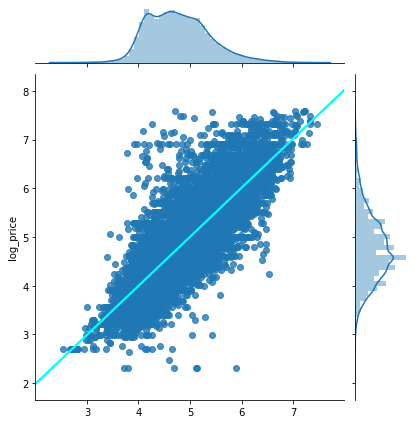

In [74]:
sns.jointplot(x=predict_values,y=y_test_train_numeric,joint_kws={'line_kws':{'color':'cyan'}},kind='reg')

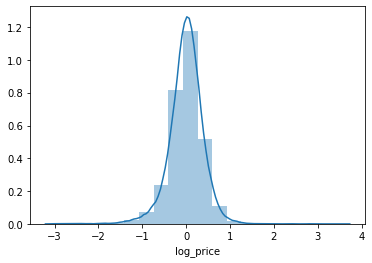

In [75]:
sns.distplot((predict_values - y_test_train_numeric), bins = 20)

In [76]:
pd.DataFrame({"id":log_ids.values,"log_price":predicts}).to_csv("Revannth_submission.csv",index=False)